### IMPORTS 
We set up our entire working environment: we imported all the libraries we need to handle images, data, neural models, and visualizations. Then we defined the main parameters of our project — such as image size, batch size, number of classes, and number of epochs — and we set the random seed to keep our experiments reproducible. Finally, we printed out the device we’re running on, so we immediately know whether we're using a GPU or a CPU.

In [1]:
# IMPORTS 
import os
import glob
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import gradio as gr

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler, Subset
from torchvision import transforms, models
from torch.cuda.amp import GradScaler, autocast

# Sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.manifold import TSNE


# CONFIGURATION
SEED = 1526
IMG_SIZE = 300
BATCH_SIZE = 32
NUM_CLASSES = 7
FOLDS = 5
EPOCHS = 15
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(SEED)
print(f"Device: {DEVICE} | Resolution: {IMG_SIZE}x{IMG_SIZE}")

Device: cuda | Resolution: 300x300


### DATA PREPARATION
We prepared the dataset. First, we defined the base path and the two folders containing the HAM10000 images. Then we loaded the metadata file and created a mapping that links each image_id to the actual image file path.
To avoid any form of leakage, we removed duplicates based on the lesion ID, ensuring that each lesion appears only once in the final dataset.
Finally, we encoded the target labels by creating a mapping from the original text labels to numeric indices and added the label_idx column.
At the end, we printed the number of samples remaining after the cleaning process.

In [2]:
# DATA PREPARATION 
base_path = "/kaggle/input/skin-cancer-mnist-ham10000/"
img_dirs = [os.path.join(base_path, "HAM10000_images_part_1"),
            os.path.join(base_path, "HAM10000_images_part_2")]

# Load & Map
df = pd.read_csv(os.path.join(base_path, "HAM10000_metadata.csv"))
image_map = {os.path.splitext(os.path.basename(x))[0]: x 
             for d in img_dirs for x in glob.glob(os.path.join(d, "*.jpg"))}
df['path'] = df['image_id'].map(image_map)

# Deduplication (Anti-Leakage)
df_unique = df.drop_duplicates(subset=['lesion_id'], keep='first').reset_index(drop=True)

# Target Encoding
CLASSES_MAP = {label: idx for idx, label in enumerate(sorted(df_unique['dx'].unique()))}
df_unique['label_idx'] = df_unique['dx'].map(CLASSES_MAP)

print(f"Cleaned Dataset: {len(df_unique)} samples")

Cleaned Dataset: 7470 samples


### EDA & DISTRIBUTION ANALYSIS 
We built the tools for exploring our dataset and understanding how the classes are distributed.
First, we created a function that analyzes class imbalance. It plots the distribution of all diagnosis classes using a bar chart, labels each bar with both the raw count and its percentage, and then prints useful imbalance metrics—such as the dominant class, the minority class, and the imbalance ratio. We also added a short interpretation to highlight how misleading accuracy can be when the dataset is heavily skewed, and we suggested using a WeightedRandomSampler together with Focal Loss as a solution.

Next, we defined a second function that shows one representative image for each class. This helps us visually confirm that the image paths are correct and that the class-to-image mapping works as expected. The function loads one sample per class and displays them side by side.

Finally, we executed both functions on our cleaned dataset to immediately visualize the class distribution and inspect sample images for each category.

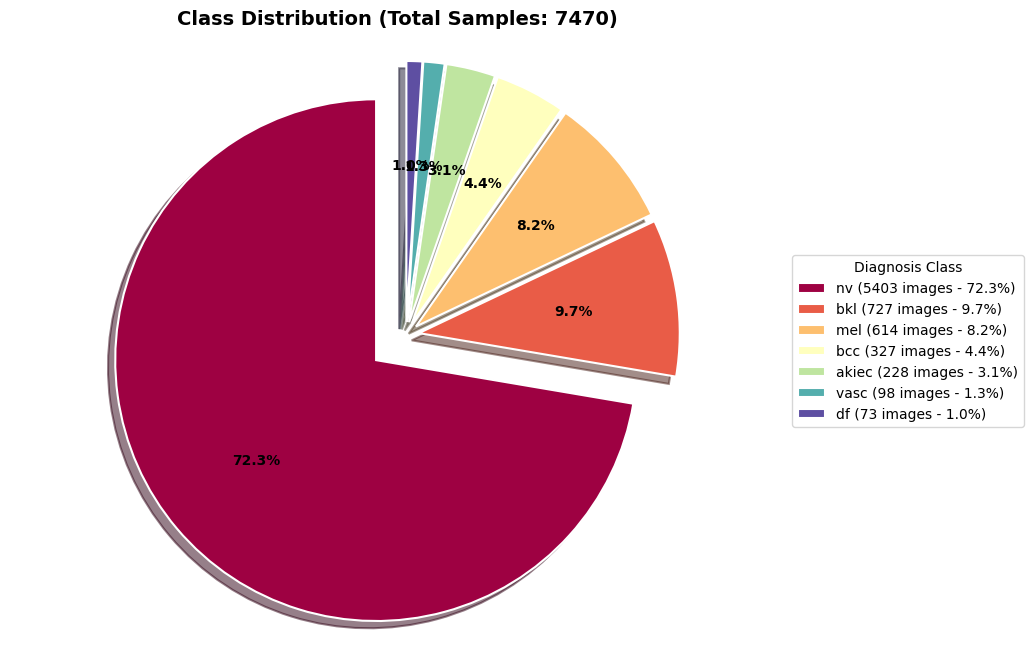


>>> IMBALANCE METRICS
Dominant Class: 'nv' (5403)
Minority Class: 'df' (73)
Imbalance Ratio: 1 : 74.0
------------------------------


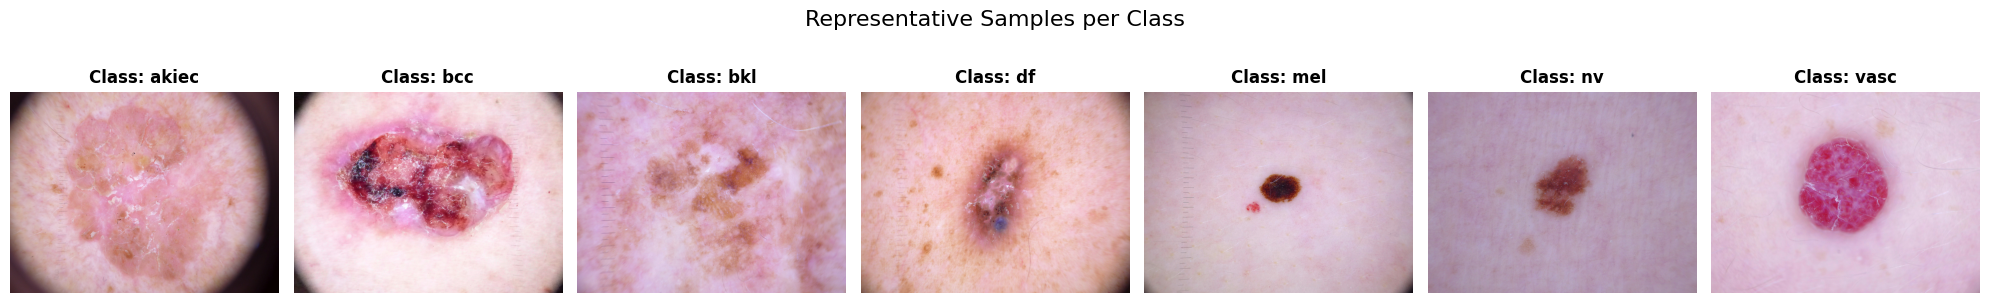

In [3]:
# EDA & DISTRIBUTION ANALYSIS 

def analyze_class_imbalance(df, class_col='dx'):
    """
    Visualizes class distribution using a styled pie chart and calculates imbalance metrics.
    """
    plt.figure(figsize=(10, 8))
    
    # 1. Styled Pie Chart
    counts = df[class_col].value_counts().sort_values(ascending=False)
    total = len(df)
    
    # Styling details
    explode = [0.05] * len(counts) 
    explode[0] = 0.15              
    colors = plt.cm.Spectral(np.linspace(0, 1, len(counts)))
    
    # Simple label formatting
    def autopct_format(pct):
        return f"{pct:.1f}%"

    legend_labels = [
        f"{idx} ({counts.loc[idx]} images - {100 * counts.loc[idx]/total:.1f}%)"
        for idx in counts.index
    ]

    plt.pie(
        counts.values, 
        autopct=autopct_format, # Only percentage inside the slice
        startangle=90, 
        explode=explode,     
        shadow=True,         
        colors=colors,       
        wedgeprops={'edgecolor': 'white', 'linewidth': 1.5},
        textprops={'fontsize': 10, 'color': 'black', 'fontweight': 'bold'}
    )
    
    plt.axis('equal') # Ensures pie chart is circular
    
    plt.title(f"Class Distribution (Total Samples: {total})", fontsize=14, fontweight='bold')
    
    plt.legend(
        legend_labels,
        title="Diagnosis Class",
        loc="center left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=10
    )

    plt.show()
    
    # 2. Quantitative Imbalance
    max_cls = counts.index[0]
    min_cls = counts.index[-1]
    ratio = counts.iloc[0] / counts.iloc[-1]
    
    print(f"\n>>> IMBALANCE METRICS")
    print(f"Dominant Class: '{max_cls}' ({counts.iloc[0]})")
    print(f"Minority Class: '{min_cls}' ({counts.iloc[-1]})")
    print(f"Imbalance Ratio: 1 : {ratio:.1f}")
    print("-" * 30)
    

def show_class_samples(df, class_col='dx', path_col='path', num_samples=7):
    """
    Displays one representative sample per class to verify mapping.
    """
    classes = df[class_col].unique()
    fig, axes = plt.subplots(1, len(classes), figsize=(20, 3))
    
    for i, cls in enumerate(sorted(classes)):
        sample_path = df[df[class_col] == cls][path_col].iloc[0]
        img = Image.open(sample_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Class: {cls}", fontweight='bold')
        axes[i].axis('off')
    
    plt.suptitle(f"Representative Samples per Class", y=1.05, fontsize=16)
    plt.tight_layout()
    plt.show()

# Immediate execution
analyze_class_imbalance(df_unique)
show_class_samples(df_unique)

### ADVANCED METADATA ANALYSIS
We performed a deeper exploration of the metadata by building a small dashboard with two visualizations.
First, we plotted the age distribution for each diagnosis using a boxen plot, which is more informative than a regular boxplot when dealing with long tails. We cleaned out missing age values, displayed how age varies across conditions, and added a short annotation to highlight that some diseases—like AKIEC or BCC—tend to affect older individuals.

Second, we created a heatmap showing the relationship between anatomical localization and diagnosis. We computed a contingency table, normalized it by diagnosis, and visualized how frequently each body site appears for each disease. This helps us spot patterns such as hotspots or uniform distributions.

At the end, we printed a few clinical insights to guide interpretation—for example, expected age trends or possible biases in location data.

/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

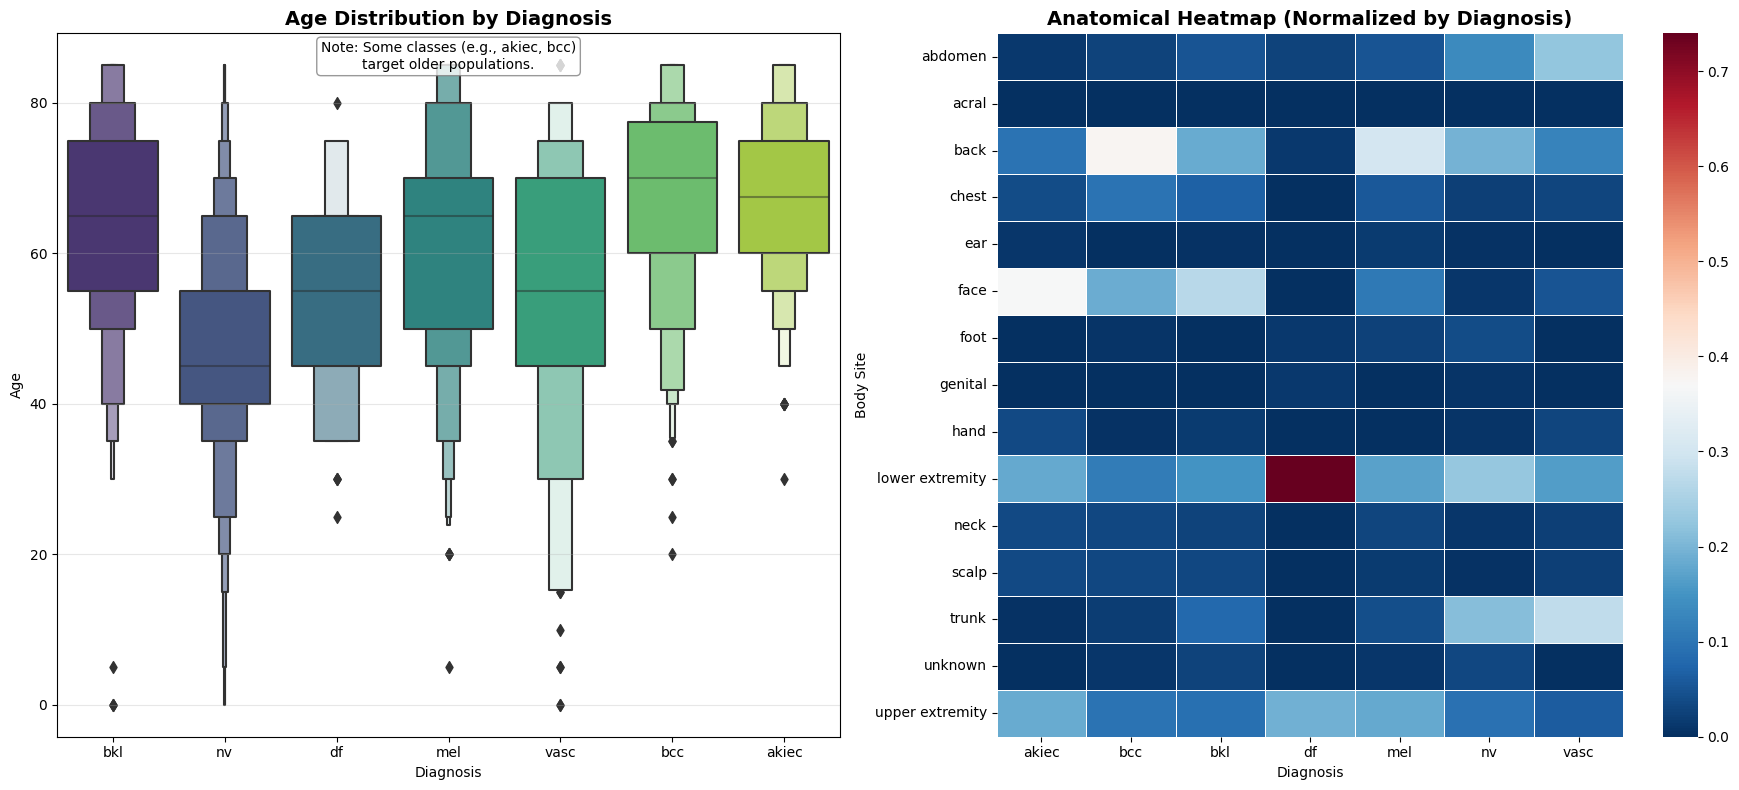


CLINICAL INSIGHTS:
1. Age: 'akiec' (Actinic Keratosis) and 'bcc' should show higher median age (accumulated sun exposure).
2. Location: Check if 'mel' (Melanoma) has specific hotspots or is uniformly distributed.


In [4]:
# ADVANCED METADATA ANALYSIS 

def plot_metadata_dashboard(df):
    """
    Plots Age distribution per diagnosis and Anatomical localization heatmap.
    """
    fig = plt.figure(figsize=(18, 8))
    gs = fig.add_gridspec(1, 2)
    
    # 1. Age Distribution (Boxen Plot)
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Clean NaN ages for plotting
    df_clean = df.dropna(subset=['age'])
    
    sns.boxenplot(data=df_clean, x='dx', y='age', palette='viridis', ax=ax1)
    ax1.set_title("Age Distribution by Diagnosis", fontsize=14, fontweight='bold')
    ax1.set_xlabel("Diagnosis")
    ax1.set_ylabel("Age")
    ax1.grid(True, axis='y', alpha=0.3)
    
    # Insight annotation
    avg_age_bkl = df_clean[df_clean['dx']=='bkl']['age'].mean()
    ax1.text(0.5, 0.95, f"Note: Some classes (e.g., akiec, bcc)\ntarget older populations.", 
             transform=ax1.transAxes, ha='center', fontsize=10, 
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

    # 2. Anatomical Localization vs Diagnosis
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Contingency Table
    ct = pd.crosstab(df['localization'], df['dx'])
    # Normalize by column (Diagnosis) to see prevalence per body part for that disease
    ct_norm = ct.div(ct.sum(axis=0), axis=1)
    
    sns.heatmap(ct_norm, cmap='RdBu_r', annot=False, fmt='.2f', linewidths=.5, ax=ax2)
    ax2.set_title("Anatomical Heatmap (Normalized by Diagnosis)", fontsize=14, fontweight='bold')
    ax2.set_ylabel("Body Site")
    ax2.set_xlabel("Diagnosis")
    
    plt.tight_layout()
    plt.show()

    # Textual Insight
    print("\nCLINICAL INSIGHTS:")
    print("1. Age: 'akiec' (Actinic Keratosis) and 'bcc' should show higher median age (accumulated sun exposure).")
    print("2. Location: Check if 'mel' (Melanoma) has specific hotspots or is uniformly distributed.")
    

# EXECUTION
plot_metadata_dashboard(df_unique)

### DATASET
We defined our custom PyTorch dataset class called SkinDataset.
We designed it so that it takes a dataframe and an optional set of transforms. The __len__ method simply returns the number of samples in the dataset, which PyTorch needs for batching.

In the __getitem__ method, we retrieve a row from the dataframe, load the corresponding image from disk, and convert it to RGB. If any transformations were provided, we apply them to the image.
Finally, we return the processed image together with its numeric label.

This dataset class allows us to easily plug our data into PyTorch’s DataLoader for training and evaluation.

In [5]:
# DATASET 
class SkinDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['path']).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, row['label_idx']

###  TRANSFORMS 
We set up the image transformations used during training and validation.
We began by defining the normalization statistics, which match the standard ImageNet mean and standard deviation, since our model will likely be pretrained on ImageNet.

For training, we created a heavy augmentation pipeline. We resize the images, apply random flips, affine transformations, color jitter, and even random erasing. These augmentations help the model generalize better by exposing it to many variations of the same lesion. After converting the image to a tensor, we normalize it using the predefined statistics.

For validation, we kept things much simpler. We only resize the images, convert them to tensors, and apply the same normalization. No augmentations are used here because we want to measure the model’s performance on clean, unmodified data.

Together, these two pipelines ensure that training is robust while validation remains consistent and fair.

In [6]:
# TRANSFORMS 
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))

# Heavy Augmentation
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=45, translate=(0.2, 0.2), scale=(0.8, 1.2), shear=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(*stats),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.15)) 
])

# Validation
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

### MIXUP
In this cell, we implemented the MixUp augmentation technique.
First, we defined a function that takes a batch of images and labels and mixes them pairwise. We sample a lambda value from a Beta distribution, shuffle the batch, and then create a blended image by combining two samples using that lambda. We also keep track of both original labels because MixUp relies on a weighted combination of targets.

Then, we created a custom loss function for MixUp. Instead of computing the loss against a single label, we compute a weighted sum of the losses for both labels, using the same lambda value that mixed the images.

Together, these functions allow us to train the model with MixUp, which helps reduce overfitting and improves robustness by encouraging smoother decision boundaries.

In [7]:
# MIXUP
def mixup_data(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    index = torch.randperm(x.size(0)).to(DEVICE)
    mixed_x = lam * x + (1 - lam) * x[index]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

### FOCAL-LOSS FUNCTION
We implemented our custom Focal Loss, which is designed to handle class imbalance more effectively.
Focal Loss extends standard cross-entropy by down-weighting easy examples and focusing more on hard, misclassified samples—something that is especially useful when some classes are under-represented.

Inside the forward method, we first compute the cross-entropy loss for each sample without reduction. From that, we derive the predicted probability for the correct class. We then build the focal term which increases the contribution of difficult examples.

Finally, we apply the chosen reduction (mean, sum, or none) to obtain the final loss value.

Using this loss helps us train a more balanced and robust model when dealing with highly imbalanced datasets.

In [8]:
# FOCAL-LOSS FUNCTION
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * CE_loss

        if self.reduction == 'mean': return torch.mean(F_loss)
        elif self.reduction == 'sum': return torch.sum(F_loss)
        else: return F_loss

### MODEL: EFFICIENTNET-B3
e built our classification model using a pretrained EfficientNet-B3.
We started by loading the architecture with ImageNet weights, which gives us a strong feature extractor right from the beginning.

Then we accessed the number of input features of the final classifier layer and replaced the original head with our own custom one. Our new classifier consists of a dropout layer, added to reduce overfitting, and a linear layer that outputs the number of classes in our dataset.

Finally, we moved the whole model to the selected device (GPU or CPU) and returned it.

In [9]:
# MODEL 
def build_model(num_classes):
    model = models.efficientnet_b3(weights='IMAGENET1K_V1')
    in_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4),
        nn.Linear(in_features, num_classes)
    )
    return model.to(DEVICE)

### TTA HELPER 
We implemented a helper function for Test-Time Augmentation (TTA).
We set the model to evaluation mode and disable gradient computation to speed up inference.

For each batch of images, we generate predictions in three ways:

1) the original images

2) horizontally flipped images

3) vertically flipped images

We pass each version through the model, apply softmax to obtain probabilities, and then average the three predictions. This averaging helps smooth out noise and often improves final accuracy.

All the averaged predictions are collected and stacked into a single NumPy array, which we return as the TTA output.

In [10]:
# TTA HELPER 
@torch.no_grad()
def run_tta(model, loader, device):
    model.eval()
    all_preds = []
    
    for images, _ in tqdm(loader, desc="TTA Inference", leave=False):
        images = images.to(device)
        # Original + HFlip + VFlip
        p1 = model(images).softmax(1)
        p2 = model(TF.hflip(images)).softmax(1)
        p3 = model(TF.vflip(images)).softmax(1)
        
        p_avg = (p1 + p2 + p3) / 3.0
        all_preds.append(p_avg.cpu().numpy())
        
    return np.vstack(all_preds)

### TRAINER 
The code shapes a Trainer class that naturally guides the whole training workflow, keeping the model, optimizer, scheduler, and loss function aligned and working together. Mixup and mixed precision slip into the process to make learning smoother and more efficient. Training and validation unfold through two clear methods, giving the routine a steady rhythm and keeping everything easy to follow and reuse.

In [11]:
# TRAINER 
class Trainer:
    def __init__(self, model, optimizer, scheduler, criterion):
        self.model = model
        self.opt = optimizer
        self.sched = scheduler
        self.crit = criterion
        self.scaler = GradScaler()

    def train_epoch(self, loader):
        self.model.train()
        avg_loss = 0
        
        for x, y in tqdm(loader, desc="Train", leave=False):
            x, y = x.to(DEVICE), y.to(DEVICE)
            # Mixup
            x, y_a, y_b, lam = mixup_data(x, y, alpha=0.4)
            
            self.opt.zero_grad()
            with autocast():
                out = self.model(x)
                loss = mixup_criterion(self.crit, out, y_a, y_b, lam)
            
            self.scaler.scale(loss).backward()
            self.scaler.step(self.opt)
            self.scaler.update()
            avg_loss += loss.item()
            
        return avg_loss / len(loader)

    @torch.no_grad()
    def validate(self, loader):
        self.model.eval()
        avg_loss = 0
        for x, y in loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = self.model(x)
            loss = self.crit(out, y)
            avg_loss += loss.item()
        return avg_loss / len(loader)

### MAIN EXECUTION 
This block lays out the full training routine across multiple folds, letting the whole process unfold step by step. The data is split in a balanced way, each fold gets its own loaders, and a weighted sampler helps the model see harder classes more often. For every fold a fresh model, optimizer, scheduler, and loss function are set up, and the training loop moves through the epochs while keeping track of how things evolve. The best version of each model is saved as soon as validation improves, and at the end a TTA pass fills in the out-of-fold predictions. Everything flows together, giving the training a steady structure and a clear path from start to finish.

In [12]:
# MAIN EXECUTION 
targets = df_unique['label_idx'].values
skf = StratifiedKFold(n_splits=FOLDS, shuffle=True, random_state=SEED)

oof_preds = np.zeros((len(df_unique), NUM_CLASSES))
oof_targets = np.zeros(len(df_unique))
history_log = {'train_loss': [], 'val_loss': []}

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets)), targets)):
    print(f"\n>>> FOLD {fold+1}/{FOLDS}")
    
    # Data Setup
    train_sub = Subset(SkinDataset(df_unique, train_transform), train_idx)
    val_sub = Subset(SkinDataset(df_unique, val_transform), val_idx)
    
    # Weighted Sampler
    y_train = targets[train_idx]
    class_weights = 1. / np.bincount(y_train)
    sample_weights = [class_weights[t] for t in y_train]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
    
    train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2)
    val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    # Model Setup
    model = build_model(NUM_CLASSES)
    optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    criterion = FocalLoss(gamma=2.0)
    
    trainer = Trainer(model, optimizer, scheduler, criterion)
    
    # Loop
    current_hist = {'train': [], 'val': []}
    best_loss = float('inf')
    
    for epoch in range(EPOCHS):
        t_loss = trainer.train_epoch(train_loader)
        v_loss = trainer.validate(val_loader)
        scheduler.step()
        
        current_hist['train'].append(t_loss)
        current_hist['val'].append(v_loss)
        
        if v_loss < best_loss:
            best_loss = v_loss
            torch.save(model.state_dict(), f"effnetb3_fold{fold}.pth")
            
        print(f"Ep {epoch+1} | T: {t_loss:.4f} | V: {v_loss:.4f}")
        
    # Final Inference (TTA) on Best Model
    print("Running TTA...")
    model.load_state_dict(torch.load(f"effnetb3_fold{fold}.pth"))
    oof_preds[val_idx] = run_tta(model, val_loader, DEVICE)
    oof_targets[val_idx] = targets[val_idx]

    # Save history for visualization
    history_log['train_loss'] = current_hist['train']
    history_log['val_loss'] = current_hist['val']

print("\nAll Folds Complete.")


>>> FOLD 1/5


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 170MB/s] 
/tmp/ipykernel_47/3088632016.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = GradScaler()


Train:   0%|          | 0/187 [00:00<?, ?it/s]

/tmp/ipykernel_47/3088632016.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Ep 1 | T: 0.7740 | V: 0.4037


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.5915 | V: 0.3070


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.5271 | V: 0.2289


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4903 | V: 0.2433


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4290 | V: 0.2150


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.4012 | V: 0.2181


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.4203 | V: 0.2150


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.3892 | V: 0.2218


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3939 | V: 0.1972


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.4128 | V: 0.2198


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3916 | V: 0.1694


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3624 | V: 0.1767


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3327 | V: 0.1754


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3766 | V: 0.1794


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3373 | V: 0.1628
Running TTA...


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


>>> FOLD 2/5


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 1 | T: 0.8182 | V: 0.3121


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.5742 | V: 0.2583


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.5442 | V: 0.2847


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4796 | V: 0.2294


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4947 | V: 0.2501


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.4590 | V: 0.2299


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.4649 | V: 0.1937


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.4084 | V: 0.1874


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3926 | V: 0.2223


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.3895 | V: 0.2270


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3498 | V: 0.2581


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3562 | V: 0.2150


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3527 | V: 0.2154


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3748 | V: 0.1982


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3486 | V: 0.1915
Running TTA...


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


>>> FOLD 3/5


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 1 | T: 0.7735 | V: 0.3951


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.5722 | V: 0.3235


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.5045 | V: 0.2886


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4787 | V: 0.2760


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4791 | V: 0.2610


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.4205 | V: 0.2684


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.4176 | V: 0.3115


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.3914 | V: 0.2566


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3461 | V: 0.2738


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.3781 | V: 0.2521


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3875 | V: 0.2556


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3849 | V: 0.2524


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3488 | V: 0.2465


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3395 | V: 0.2377


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3550 | V: 0.2372
Running TTA...


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


>>> FOLD 4/5


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 1 | T: 0.7810 | V: 0.3388


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.5783 | V: 0.3065


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.5065 | V: 0.3134


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4646 | V: 0.2493


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4723 | V: 0.2687


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.4128 | V: 0.3201


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.4259 | V: 0.2797


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.3806 | V: 0.2582


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3604 | V: 0.2256


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.3710 | V: 0.2181


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3732 | V: 0.2230


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3587 | V: 0.2091


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3586 | V: 0.2104


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3334 | V: 0.2112


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3602 | V: 0.2048
Running TTA...


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


>>> FOLD 5/5


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 1 | T: 0.7794 | V: 0.3508


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 2 | T: 0.6027 | V: 0.3388


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 3 | T: 0.5353 | V: 0.2874


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 4 | T: 0.4827 | V: 0.2556


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 5 | T: 0.4971 | V: 0.2633


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 6 | T: 0.4201 | V: 0.2154


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 7 | T: 0.4196 | V: 0.2288


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 8 | T: 0.4115 | V: 0.1941


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 9 | T: 0.3896 | V: 0.1989


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 10 | T: 0.3725 | V: 0.2019


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 11 | T: 0.3812 | V: 0.2180


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 12 | T: 0.3342 | V: 0.2009


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 13 | T: 0.3738 | V: 0.1896


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 14 | T: 0.3670 | V: 0.1885


Train:   0%|          | 0/187 [00:00<?, ?it/s]

Ep 15 | T: 0.3642 | V: 0.2093
Running TTA...


TTA Inference:   0%|          | 0/47 [00:00<?, ?it/s]


All Folds Complete.


### SMOOTHED LOSS CURVES 
The function shapes a clear view of how the loss evolves over time by taking the raw training curves and softening them through exponential smoothing. Both the original and the smoothed lines are drawn together so the noisy jumps remain visible while the underlying trend becomes easier to read.

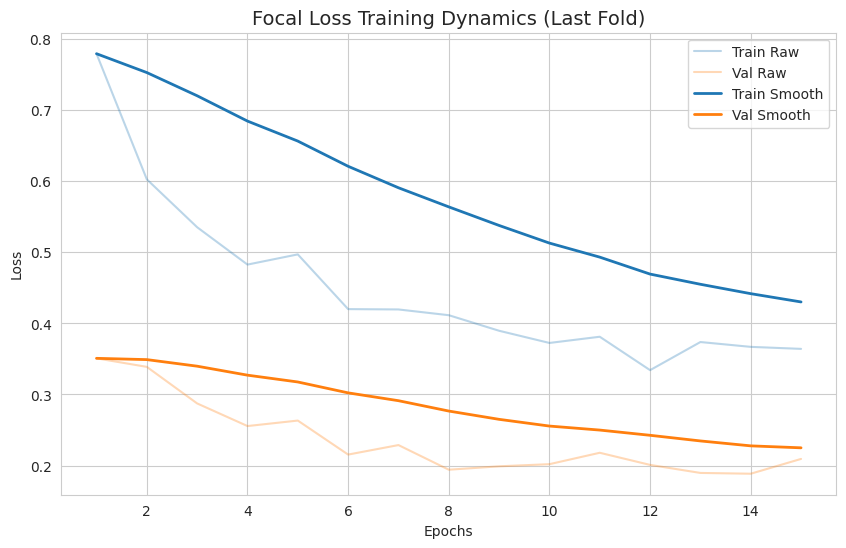

In [13]:
# SMOOTHED CURVES 
def plot_smoothed(history, smooth=0.85):
    def _smooth(scalars, weight):
        last = scalars[0]
        smoothed = []
        for point in scalars:
            smoothed_val = last * weight + (1 - weight) * point
            smoothed.append(smoothed_val)
            last = smoothed_val
        return smoothed

    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(10, 6))
    sns.set_style("whitegrid")
    
    plt.plot(epochs, history['train_loss'], alpha=0.3, color='tab:blue', label='Train Raw')
    plt.plot(epochs, history['val_loss'], alpha=0.3, color='tab:orange', label='Val Raw')
    plt.plot(epochs, _smooth(history['train_loss'], smooth), color='tab:blue', lw=2, label='Train Smooth')
    plt.plot(epochs, _smooth(history['val_loss'], smooth), color='tab:orange', lw=2, label='Val Smooth')
    
    plt.title("Focal Loss Training Dynamics (Last Fold)", fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_smoothed(history_log)

### OOF CONFUSION MATRIX AND CLASSIFICATION REPORT
The confusion matrix computed on Out-Of-Fold predictions reveals the model's robust classification dynamics despite the heavy class imbalance. We observe excellent stability on the dominant 'nv' class, which largely drives the global accuracy, while the performance on Melanoma ('mel') reflects a necessary medical trade-off: the model prioritizes Recall over Precision to minimize missed diagnoses, leading to a "prudent" behavior where some benign lesions are flagged as malignant. While distinct categories like 'vasc' are isolated with high accuracy due to their unique features, some confusion persists between visually similar non-melanoma carcinomas (AKIEC and BCC). Overall, the application of WeightedRandomSampler and Focal Loss successfully prevented the model from collapsing onto the majority class, maintaining crucial sensitivity for the minority classes.

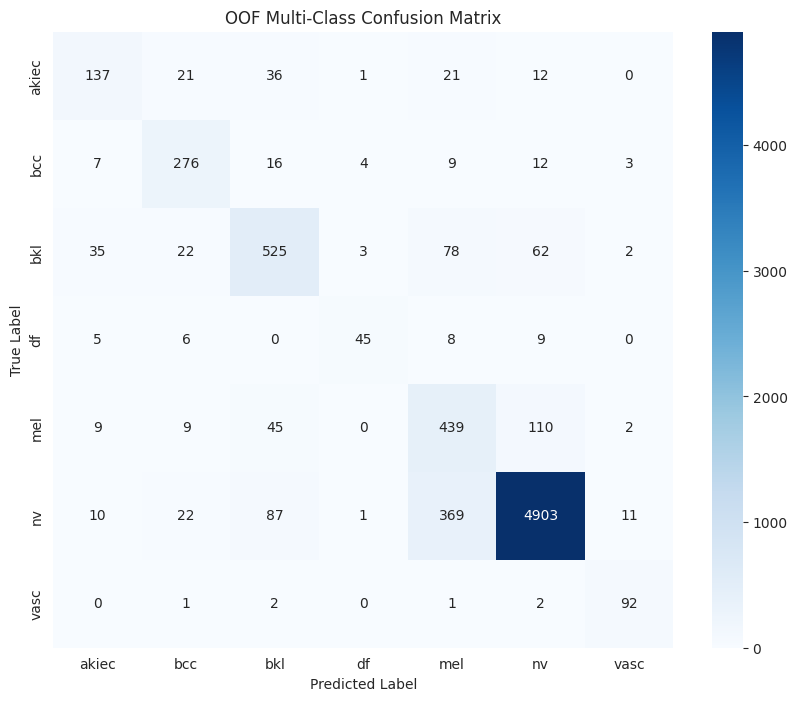

In [14]:
# OOF CONFUSION MATRIX
# 1. Get hard predictions (index of the class with maximum probability)
y_pred = np.argmax(oof_preds, axis=1)
y_true = oof_targets.astype(int) 

# 2. Calculate the Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# 3. Define class names
num_classes_inferred = len(np.unique(y_true))
class_names = sorted(df_unique['dx'].unique())
# 4. Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=class_names, 
    yticklabels=class_names
)
plt.title('OOF Multi-Class Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [15]:
# OOF MULTICLASS CLASSIFICATION REPORT

# 1. Setup Data & Labels
target_names = sorted(CLASSES_MAP.keys())

# Get hard predictions (argmax) and true labels
y_pred = np.argmax(oof_preds, axis=1)
y_true = oof_targets.astype(int)

# 2. Generate Report as Dictionary
report = classification_report(y_true, y_pred, target_names=target_names, output_dict=True)

# 3. Convert to DataFrame
df_report = pd.DataFrame(report).transpose()

# 4. Scale
metric_cols = ['precision', 'recall', 'f1-score']
df_report[metric_cols] = df_report[metric_cols] * 100

# 5. Final Formatting
df_report = df_report.rename(index={'accuracy': 'Global Accuracy'})

# Print with Markdown formatting and 1 decimal place
print("\nOOF Multi-Class Classification Report (%)")
print(df_report.to_markdown(floatfmt=".1f"))


OOF Multi-Class Classification Report (%)
|                 |   precision |   recall |   f1-score |   support |
|:----------------|------------:|---------:|-----------:|----------:|
| akiec           |        67.5 |     60.1 |       63.6 |     228.0 |
| bcc             |        77.3 |     84.4 |       80.7 |     327.0 |
| bkl             |        73.8 |     72.2 |       73.0 |     727.0 |
| df              |        83.3 |     61.6 |       70.9 |      73.0 |
| mel             |        47.5 |     71.5 |       57.1 |     614.0 |
| nv              |        95.9 |     90.7 |       93.3 |    5403.0 |
| vasc            |        83.6 |     93.9 |       88.5 |      98.0 |
| Global Accuracy |        85.9 |     85.9 |       85.9 |       0.9 |
| macro avg       |        75.6 |     76.4 |       75.3 |    7470.0 |
| weighted avg    |        87.8 |     85.9 |       86.6 |    7470.0 |


### BINARY ANALYSIS 
The function turns the multi-class predictions into a simple malignant-versus-benign view, grouping the classes that represent risk into a single category. It compares these binary labels with the model’s predictions and prints a clear classification report that highlights how well the model separates the two groups. The confusion matrix is then shown both in raw counts and normalized form, giving a quick sense of where the model succeeds and where it hesitates.


=== CLINICAL REPORT: MALIGNANT vs BENIGN ===
              precision    recall  f1-score   support

      Benign       0.96      0.91      0.94      6301
   Malignant       0.62      0.79      0.70      1169

    accuracy                           0.89      7470
   macro avg       0.79      0.85      0.82      7470
weighted avg       0.91      0.89      0.90      7470



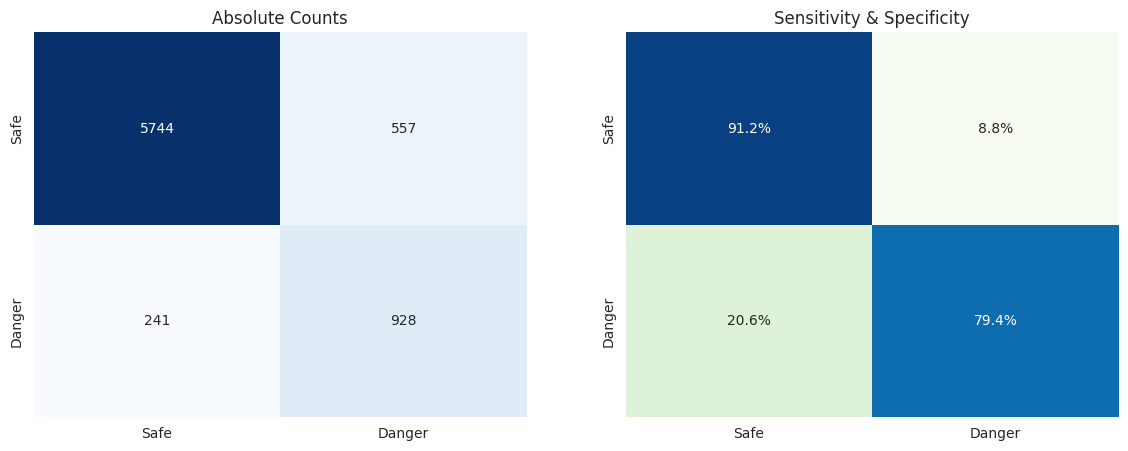

In [16]:
# BINARY ANALYSIS 
def plot_binary(y_true, y_pred_prob):
    # 1: Malignant (Mel, BCC, Akiec), 0: Benign
    target_labels = ['mel', 'bcc', 'akiec']
    MALIGNANT_IDXS = [CLASSES_MAP[label] for label in target_labels if label in CLASSES_MAP]
    y_pred_idx = np.argmax(y_pred_prob, axis=1)
    
    y_true_bin = [1 if x in MALIGNANT_IDXS else 0 for x in y_true]
    y_pred_bin = [1 if x in MALIGNANT_IDXS else 0 for x in y_pred_idx]
    
    print("\n=== CLINICAL REPORT: MALIGNANT vs BENIGN ===")
    print(classification_report(y_true_bin, y_pred_bin, target_names=['Benign', 'Malignant']))
    
    cm = confusion_matrix(y_true_bin, y_pred_bin)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Safe', 'Danger'], yticklabels=['Safe', 'Danger'])
    plt.title("Absolute Counts")
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cm_norm, annot=True, fmt='.1%', cmap='GnBu', cbar=False,
                xticklabels=['Safe', 'Danger'], yticklabels=['Safe', 'Danger'])
    plt.title("Sensitivity & Specificity")
    plt.show()

plot_binary(oof_targets, oof_preds)

### T-SNE 
The function pulls feature embeddings from the model by temporarily removing the classification head, letting the network reveal how it internally represents each image. A sample of these embeddings is gathered from the loader, squeezed into two dimensions through t-SNE, and then plotted so the structure hidden inside the feature space becomes visible. Clusters, overlaps, and outliers naturally emerge in the scatter plot, giving an intuitive sense of how the model separates classes long before the final classifier steps in.

Extracting Embeddings...
Running t-SNE...


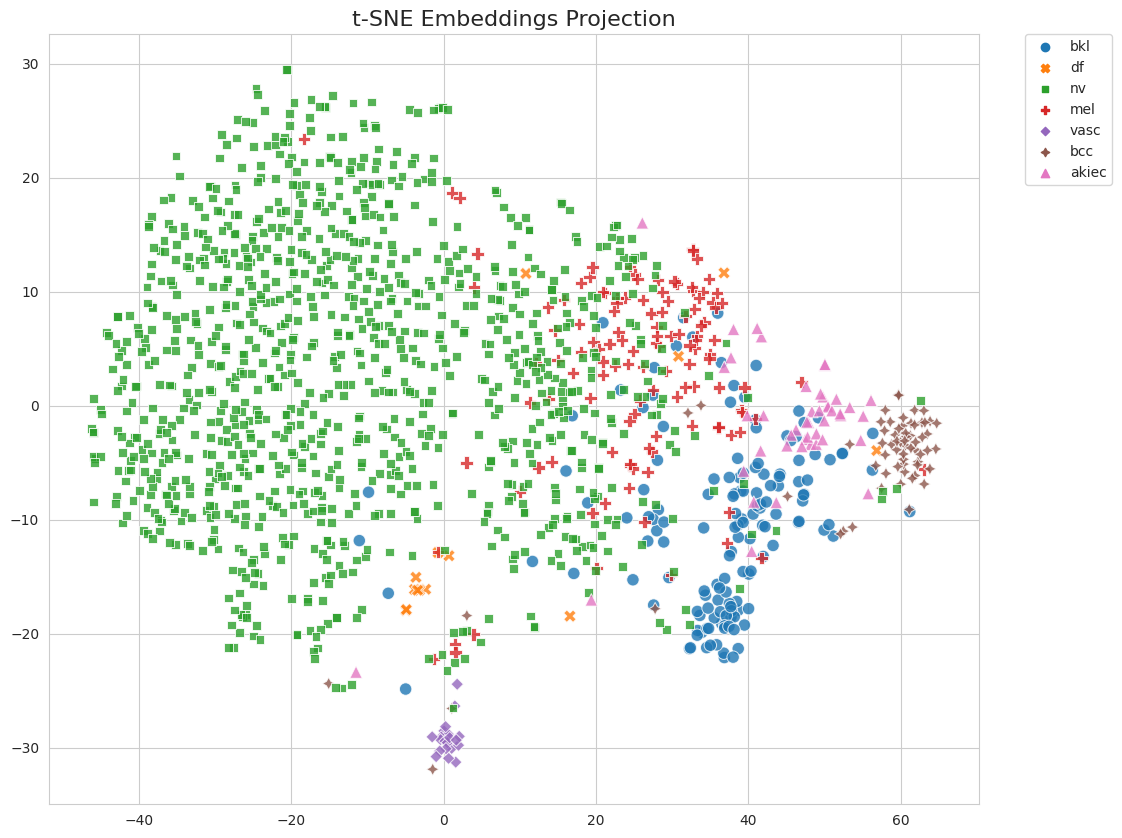

In [17]:
# T-SNE 
def visualize_tsne(model, loader, device, limit=1500):
    model.eval()
    orig_classifier = model.classifier
    model.classifier = nn.Identity() 
    idx_to_class = {v: k for k, v in CLASSES_MAP.items()}
    feats, labels = [], []
    
    print("Extracting Embeddings...")
    with torch.no_grad():
        for i, (imgs, lbls) in enumerate(loader):
            if i * loader.batch_size >= limit: break
            imgs = imgs.to(device)
            feats.append(model(imgs).cpu().numpy())
            labels.append(lbls.numpy())
            
    model.classifier = orig_classifier
    
    X = np.concatenate(feats)
    y_idx = np.concatenate(labels)
    y = [idx_to_class[idx] for idx in y_idx]
    
    print("Running t-SNE...")
    tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=SEED)
    X_embedded = tsne.fit_transform(X)
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(x=X_embedded[:,0], 
                    y=X_embedded[:,1],
                    hue=y,
                    palette='tab10',
                    style=y,
                    s=80, 
                    alpha=0.8)
    plt.title("t-SNE Embeddings Projection", fontsize=16)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

visualize_tsne(model, val_loader, DEVICE)

### Explainable AI (XAI): Grad-CAM & Confidence Analysis
To ensure model transparency, we implement Grad-CAM (Gradient-weighted Class Activation Mapping) to visualize the specific image regions driving the classification. The pipeline automatically selects a True Positive sample from the external test set to validate that the model focuses on relevant lesion morphological features rather than background artifacts. By extracting gradients from the final EfficientNet convolutional block, we generate an attention heatmap overlaid on the original image. This qualitative analysis is complemented by a confidence bar chart displaying the softmax probability distribution, providing a clear summary of the model's certainty and any potential ambiguity across classes.

Searching for a sample...


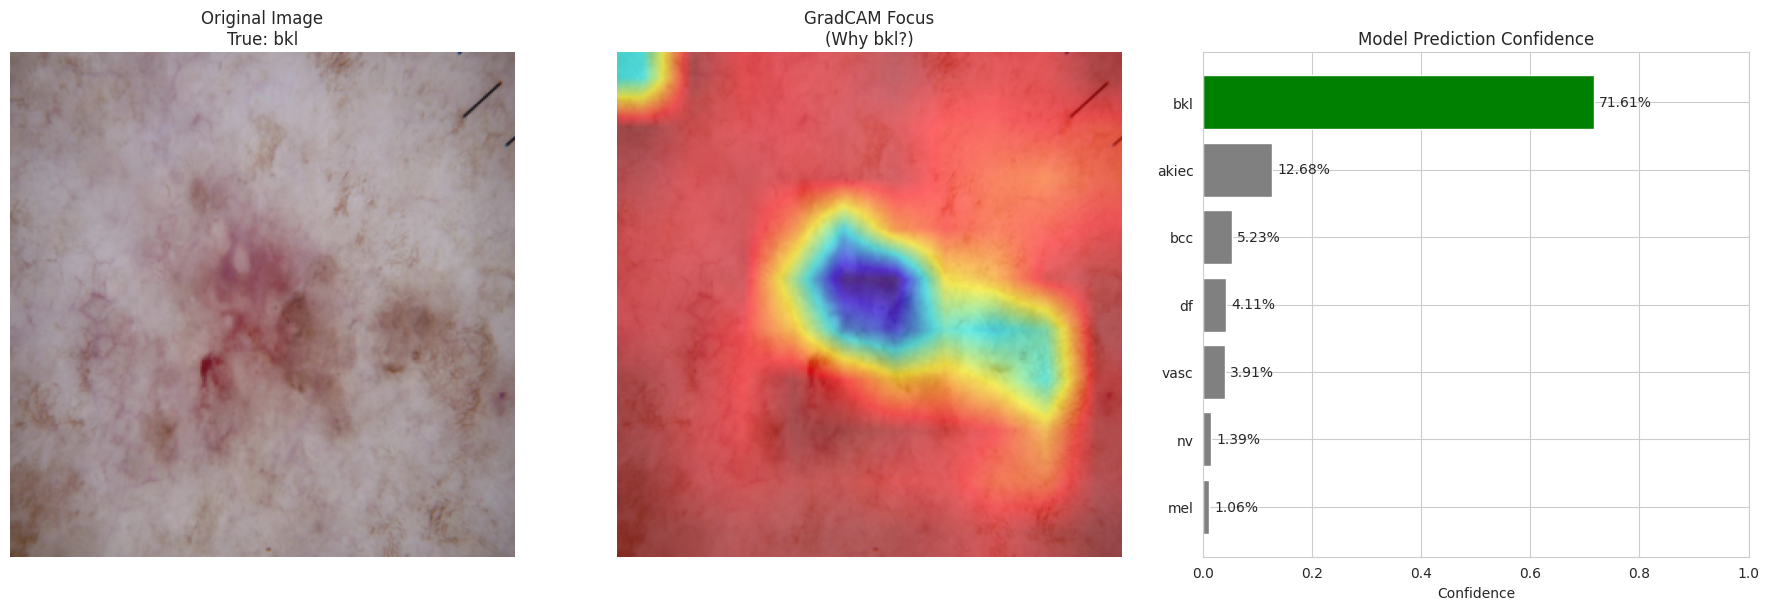

In [28]:
# GradCAM Class
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, x, class_idx):
        output = self.model(x)
        self.model.zero_grad()
        target = output[0, class_idx]
        target.backward()

        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activation = self.activations[0]
        
        for i in range(activation.shape[0]):
            activation[i, :, :] *= pooled_gradients[i]
            
        heatmap = torch.mean(activation, dim=0).cpu().detach().numpy()
        heatmap = np.maximum(heatmap, 0)
        if np.max(heatmap) != 0:
            heatmap /= np.max(heatmap)
        return heatmap, output


        
# Visualization Function
def visualize_xai_with_confidence(model, loader, device, classes_map):
    model.eval()
    
    # 1. Search for a Correct Prediction
    input_img = None
    true_label = None
    pred_probs = None
    found = False

    print("Searching for a sample...")
    
    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)
        
        with torch.enable_grad():
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)
            
            # Find a correct match
            matches = (preds == labels).nonzero(as_tuple=False)
            
            if len(matches) > 0:
                idx = matches[0].item()
                input_img = images[idx].unsqueeze(0)
                true_label = labels[idx].item()
                pred_probs = probs[idx].detach().cpu().numpy() # Save all probs
                found = True
                break
    
    if not found:
        print("No correct predictions found in this batch.")
        return

    # 2. Compute GradCAM
    target_layer = model.features[-1] 
    grad_cam = GradCAM(model, target_layer)
    mask, _ = grad_cam(input_img, true_label)
    
    # 3. Prepare Image
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    rgb_img = inv_normalize(input_img[0]).permute(1, 2, 0).cpu().numpy()
    rgb_img = np.clip(rgb_img, 0, 1)

    # 4. Prepare Heatmap Overlay
    heatmap = cv2.resize(mask, (rgb_img.shape[1], rgb_img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam_result = heatmap + np.float32(rgb_img)
    cam_result = cam_result / np.max(cam_result)

    # 5. Plotting (Image + GradCAM + Bar Chart)
    idx_to_class = {v: k for k, v in classes_map.items()}
    class_names = [idx_to_class[i] for i in range(len(classes_map))]
    
    # Sort probabilities for clean plotting
    sorted_idxs = np.argsort(pred_probs)
    sorted_probs = pred_probs[sorted_idxs]
    sorted_names = [class_names[i] for i in sorted_idxs]
    
    # Color logic: Green for correct class, Gray for others
    colors = ['gray'] * len(sorted_names)
    correct_name = idx_to_class[true_label]
    if correct_name in sorted_names:
        colors[sorted_names.index(correct_name)] = 'green'

    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    
    # A. Original
    ax[0].imshow(rgb_img)
    ax[0].set_title(f"Original Image\nTrue: {correct_name}")
    ax[0].axis('off')
    
    # B. GradCAM
    ax[1].imshow(cam_result)
    ax[1].set_title(f"GradCAM Focus\n(Why {correct_name}?)")
    ax[1].axis('off')
    
    # C. Probabilities
    y_pos = np.arange(len(sorted_names))
    ax[2].barh(y_pos, sorted_probs, color=colors)
    ax[2].set_yticks(y_pos)
    ax[2].set_yticklabels(sorted_names)
    ax[2].set_xlabel("Confidence")
    ax[2].set_title("Model Prediction Confidence")
    ax[2].set_xlim(0, 1.0)
    
    # Add text labels on bars
    for i, v in enumerate(sorted_probs):
        ax[2].text(v + 0.01, i, f"{v:.2%}", va='center')

    plt.tight_layout()
    plt.show()

# 1. Data Selection
xai_df = df_unique.sample(n=2000, random_state=SEED).reset_index(drop=True)

# 2. XAI Loader
xai_loader = DataLoader(
    SkinDataset(xai_df, transform=val_transform),
    batch_size=32,
    shuffle=True, 
    num_workers=2
)

# 3. Visualization
visualize_xai_with_confidence(model, xai_loader, DEVICE, CLASSES_MAP)

### External Test Evaluation

In this section we evaluated the model on an entirely independent dataset to measure its ability to generalize beyond the distribution it was trained on. This external test acts as a realistic stress-test: images come from different clinical sources, use different acquisition devices, and present variations in illumination, resolution, and color profiles that are not found in HAM10000. By applying the trained model directly, without any fine-tuning, we can observe how well its learned representations transfer to a new visual domain. This approach allows us to highlight strengths, reveal limitations, and understand how dataset-specific the learned decision boundaries are, offering a clearer picture of the model’s robustness in real-world scenarios.

In [19]:
# EXTERNAL TEST
NEW_DATASET_DIR = "/kaggle/input/unified-dataset-for-skin-cancer-classification/Unified_dataset/val" 
MY_TRAIN_CSV = "/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv"
SEED = 1526
TEST_SIZE = 2000

TARGET_CLASSES = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

class ExternalTestDataset(Dataset):
    def __init__(self, df, classes_map, transform=None):
        self.df = df.reset_index(drop=True)
        self.classes_map = classes_map
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        # Load image from 'filepath' column (specific to the test set structure)
        img = Image.open(row['filepath']).convert("RGB")
        
        if self.transform:
            img = self.transform(img)
            
        # Map string label to numeric index
        label_idx = self.classes_map[row['label']]
        
        return img, label_idx

def create_filtered_test_set(data_dir, train_csv):
    # 1. Load Blacklist
    df_train = pd.read_csv(train_csv)
    
    blacklist_ids = set(df_train['image_id'].astype(str).apply(lambda x: Path(x).stem))
    
    print(f"Blacklisted IDs (Training Set): {len(blacklist_ids)}")
    
    valid_data = []
    
    # 2. Scan folders and filter
    for class_name in TARGET_CLASSES:
        class_path = os.path.join(data_dir, class_name)
        if not os.path.exists(class_path):
            print(f"Warning: Folder '{class_name}' not found.")
            continue
            
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]
        
        for f in files:
            img_id = Path(f).stem
            if img_id not in blacklist_ids:
                valid_data.append({
                    'filepath': os.path.join(class_path, f),
                    'label': class_name,
                    'image_id': img_id
                })
    
    df_clean = pd.DataFrame(valid_data)
    print(f"Total Clean Images Available: {len(df_clean)}")
    
    # 3. Stratified Sampling
    if len(df_clean) > TEST_SIZE:
        _, df_test = train_test_split(
            df_clean,
            test_size=TEST_SIZE,
            stratify=df_clean['label'],
            random_state=SEED
        )
    else:
        df_test = df_clean.copy()
        
    print(f"Final Test Set: {len(df_test)} images")
    if not df_test.empty:
        print(df_test['label'].value_counts().to_string())
    
    return df_test

# Generate the dataframe
df_final_test = create_filtered_test_set(NEW_DATASET_DIR, MY_TRAIN_CSV)

Blacklisted IDs (Training Set): 10015
Total Clean Images Available: 7282
Final Test Set: 2000 images
label
nv       704
mel      573
bcc      446
akiec    139
bkl      102
vasc      20
df        16


In [20]:
# 2. Efficient Ensemble Inference (Weight Swapping)
def ensemble_inference(model, weights_paths, loader, device):
    """
    Efficient ensemble: Reuses the same model instance, swapping weights.
    """
    ensemble_logits = None
    valid_weights = [w for w in weights_paths if os.path.exists(w)]
    
    if not valid_weights:
        raise FileNotFoundError(f"No weight files found in paths: {weights_paths}")

    # Ensure model is on correct device
    model.to(device)

    for w_path in tqdm(valid_weights, desc="Ensemble Inference"):
        # Load weights into the existing model instance
        model.load_state_dict(torch.load(w_path, map_location=device))
        model.eval()
        
        fold_probs = []
        with torch.no_grad():
            for img, _ in loader:
                img = img.to(device)
                # TTA: Average (Original + Horizontal Flip)
                p1 = model(img).softmax(1)
                p2 = model(torch.flip(img, dims=[3])).softmax(1)
                avg_p = (p1 + p2) / 2.0
                fold_probs.append(avg_p.cpu().numpy())
        
        fold_res = np.concatenate(fold_probs)
        
        if ensemble_logits is None:
            ensemble_logits = fold_res
        else:
            ensemble_logits += fold_res

    return ensemble_logits / len(valid_weights)

# 3. Execution Configuration
WEIGHTS_DIR = "/kaggle/input/pesi-skin"

# Setup Loader
ext_loader = DataLoader(
    ExternalTestDataset(df_final_test, CLASSES_MAP, val_transform),
    batch_size=BATCH_SIZE, shuffle=False, num_workers=2
)

# Define weights paths from the specific dataset
weights = [os.path.join(WEIGHTS_DIR, f"effnetb3_fold{i}.pth") for i in range(FOLDS)]

# Build architecture once
model = build_model(NUM_CLASSES)

# Run Inference
probs = ensemble_inference(model, weights, ext_loader, DEVICE)
preds = np.argmax(probs, axis=1)

# 4. Generate Report
y_true = df_final_test['label'].map(CLASSES_MAP).values
target_names = [k for k, v in sorted(CLASSES_MAP.items(), key=lambda x: x[1])]

print(classification_report(y_true, preds, target_names=target_names))

Ensemble Inference:   0%|          | 0/5 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       akiec       0.31      0.28      0.30       139
         bcc       0.73      0.60      0.66       446
         bkl       0.20      0.51      0.28       102
          df       0.35      0.50      0.41        16
         mel       0.79      0.36      0.49       573
          nv       0.65      0.85      0.74       704
        vasc       0.25      0.40      0.31        20

    accuracy                           0.59      2000
   macro avg       0.47      0.50      0.45      2000
weighted avg       0.65      0.59      0.59      2000



### Metrics & Confusion Matrices

The classification report and confusion matrices show a reasonable ability to separate visually characteristic lesions but reveal class-level inconsistencies driven by distribution mismatch and altered imaging conditions. Misclassifications often occur between histologically related or morphologically similar categories, suggesting that some learned decision boundaries do not fully transfer to the new domain. Normalized matrices confirm that recall drops more significantly than precision, indicating that the model becomes more conservative when confronted with unfamiliar patterns. Although these limitations are expected under domain shift, they also point to potential future improvements through fine-tuning, domain-specific augmentations, or multi-source training.

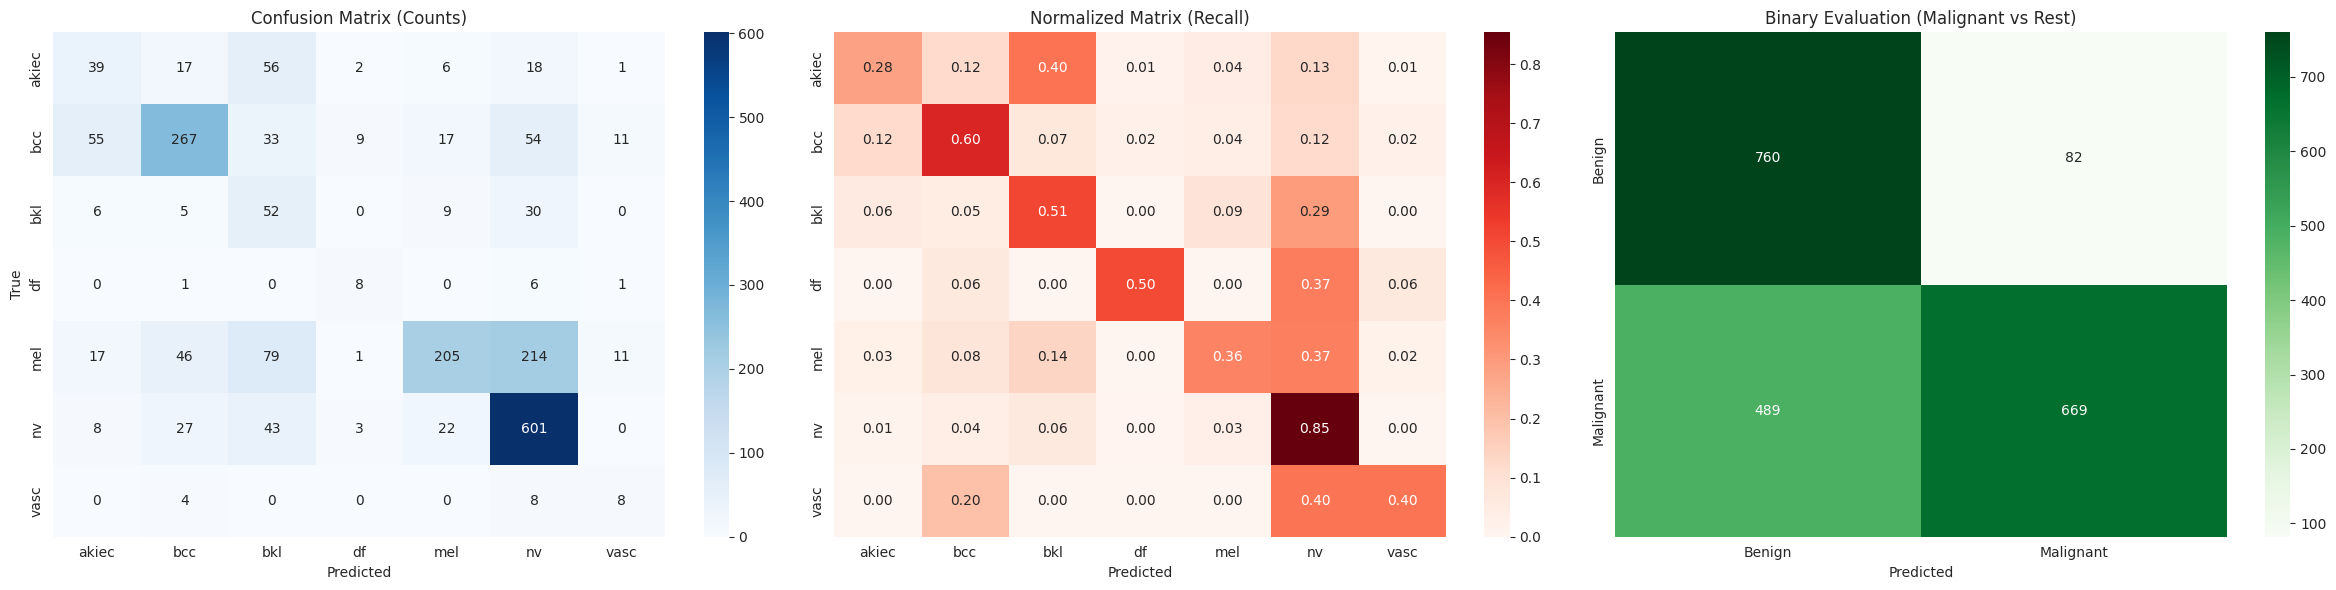

In [21]:
# 1. Setup Data & Labels
cm = confusion_matrix(y_true, preds)
class_names = [k for k, v in sorted(CLASSES_MAP.items(), key=lambda x: x[1])]

# 2. Configure Plots (3 subplots)
fig, axes = plt.subplots(1, 3, figsize=(24, 6))

# Plot A: Absolute Counts
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0], 
            xticklabels=class_names, yticklabels=class_names)
axes[0].set_title("Confusion Matrix (Counts)")
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('True')

# Plot B: Normalized (Recall)
# Add epsilon to prevent division by zero
cm_norm = cm.astype('float') / (cm.sum(axis=1)[:, np.newaxis] + 1e-9)
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Reds', ax=axes[1],
            xticklabels=class_names, yticklabels=class_names)
axes[1].set_title("Normalized Matrix (Recall)")
axes[1].set_xlabel('Predicted')

# Plot C: Binary (Malignant vs Benign) 
# Define malignant classes
malignant = ['mel', 'bcc', 'akiec'] 
mal_idxs = [CLASSES_MAP[k] for k in malignant if k in CLASSES_MAP]

# Map to binary (1=Malignant, 0=Benign)
bin_true = [1 if x in mal_idxs else 0 for x in y_true]
bin_pred = [1 if x in mal_idxs else 0 for x in preds]

# Plot Binary Matrix
sns.heatmap(confusion_matrix(bin_true, bin_pred), annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
axes[2].set_title("Binary Evaluation (Malignant vs Rest)")
axes[2].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

### Deployment & Inference Interface

In this final section, we transition from the experimental training environment to simulate a **production** scenario. The goal is to make the model tangible and usable, decoupling the training phase (static) from the inference phase (dynamic).

To achieve this, we use the `gradio` library, which allows us to build a functional web interface with minimal code overhead.

From a logical standpoint, the script below loads the **EfficientNet-B3** architecture and assigns it the weights from the **best validation fold** (the checkpoint that minimized loss), ensuring maximum generalization capabilities. The workflow is linear: the image uploaded by the user undergoes the same preprocessing as the validation phase, is processed by the neural network, and the output is converted into percentage probabilities for the diagnostic classes.

Running the cell will generate a link to test the model in real-time on new dermoscopic images.

In [22]:
# Configuration 
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = "/kaggle/input/pesi-skin/effnetb3_fold0.pth" 
IMG_SIZE = 300
# Class mapping (ensure strict alignment with our CLASSES_MAP)
LABELS = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'] 

# Preprocessing 
val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Model Loader
def load_inference_model():
    # Call your build_model function or redefine architecture here
    model = build_model(num_classes=len(LABELS)) 
    model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
    model.to(DEVICE)
    model.eval()
    return model

model = load_inference_model()

# Inference Engine
def predict_skin_lesion(image):
    if image is None:
        return None
    image = image.convert('RGB')
    # Preprocessing
    img_tensor = val_transform(image).unsqueeze(0).to(DEVICE)
    
    # Inference
    with torch.no_grad():
        logits = model(img_tensor)
        probs = torch.softmax(logits, dim=1)
    
    # Postprocessing for Gradio (Dict format: {Label: Probability})
    return {LABELS[i]: float(probs[0, i]) for i in range(len(LABELS))}

# User Interface (DEMO)
demo = gr.Interface(
    fn=predict_skin_lesion,
    inputs=gr.Image(type="pil", label="Upload Dermoscopic Image"),
    outputs=gr.Label(num_top_classes=3, label="Model Prediction"),
    title="Skin Cancer Classification Demo",
    allow_flagging="never"
)

if __name__ == "__main__":
    demo.launch(share=True)

/usr/local/lib/python3.11/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://030befb824aeb96bba.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
